In [9]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)





# note: use the following lines to avoid the warning message
#tmp = (data['quality']>qualThreshold ).astype(int)
#data['boolQuality'] = tmp

In [11]:
def createAdataset(qualThreshold):

    data['boolQuality'] = 0

    data['boolQuality'] = (data.loc[:,'quality'] > qualThreshold).astype(int)

    # convert from pandas df to tensor
    dataT = torch.tensor(data[cols2zscore].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:, None]

    train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .2)

    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    train_loader = DataLoader(train_data, batch_size = 8, shuffle = True, drop_last = True)
    test_loader = DataLoader(test_data, batch_size = len(test_data))

    return train_loader, test_loader

In [12]:
train_loader, test_loader = createAdataset(6)
qualityRatings = train_loader.dataset.tensors[1].detach()

print('%s low rated wines' %torch.sum(qualityRatings == 0).item())
print('%s high rated wines' %torch.sum(qualityRatings == 1).item() )

1113 low rated wines
164 high rated wines


In [16]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)



  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>

    x = F.leaky_relu( self.input(x) )
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    return self.output(x)

In [17]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

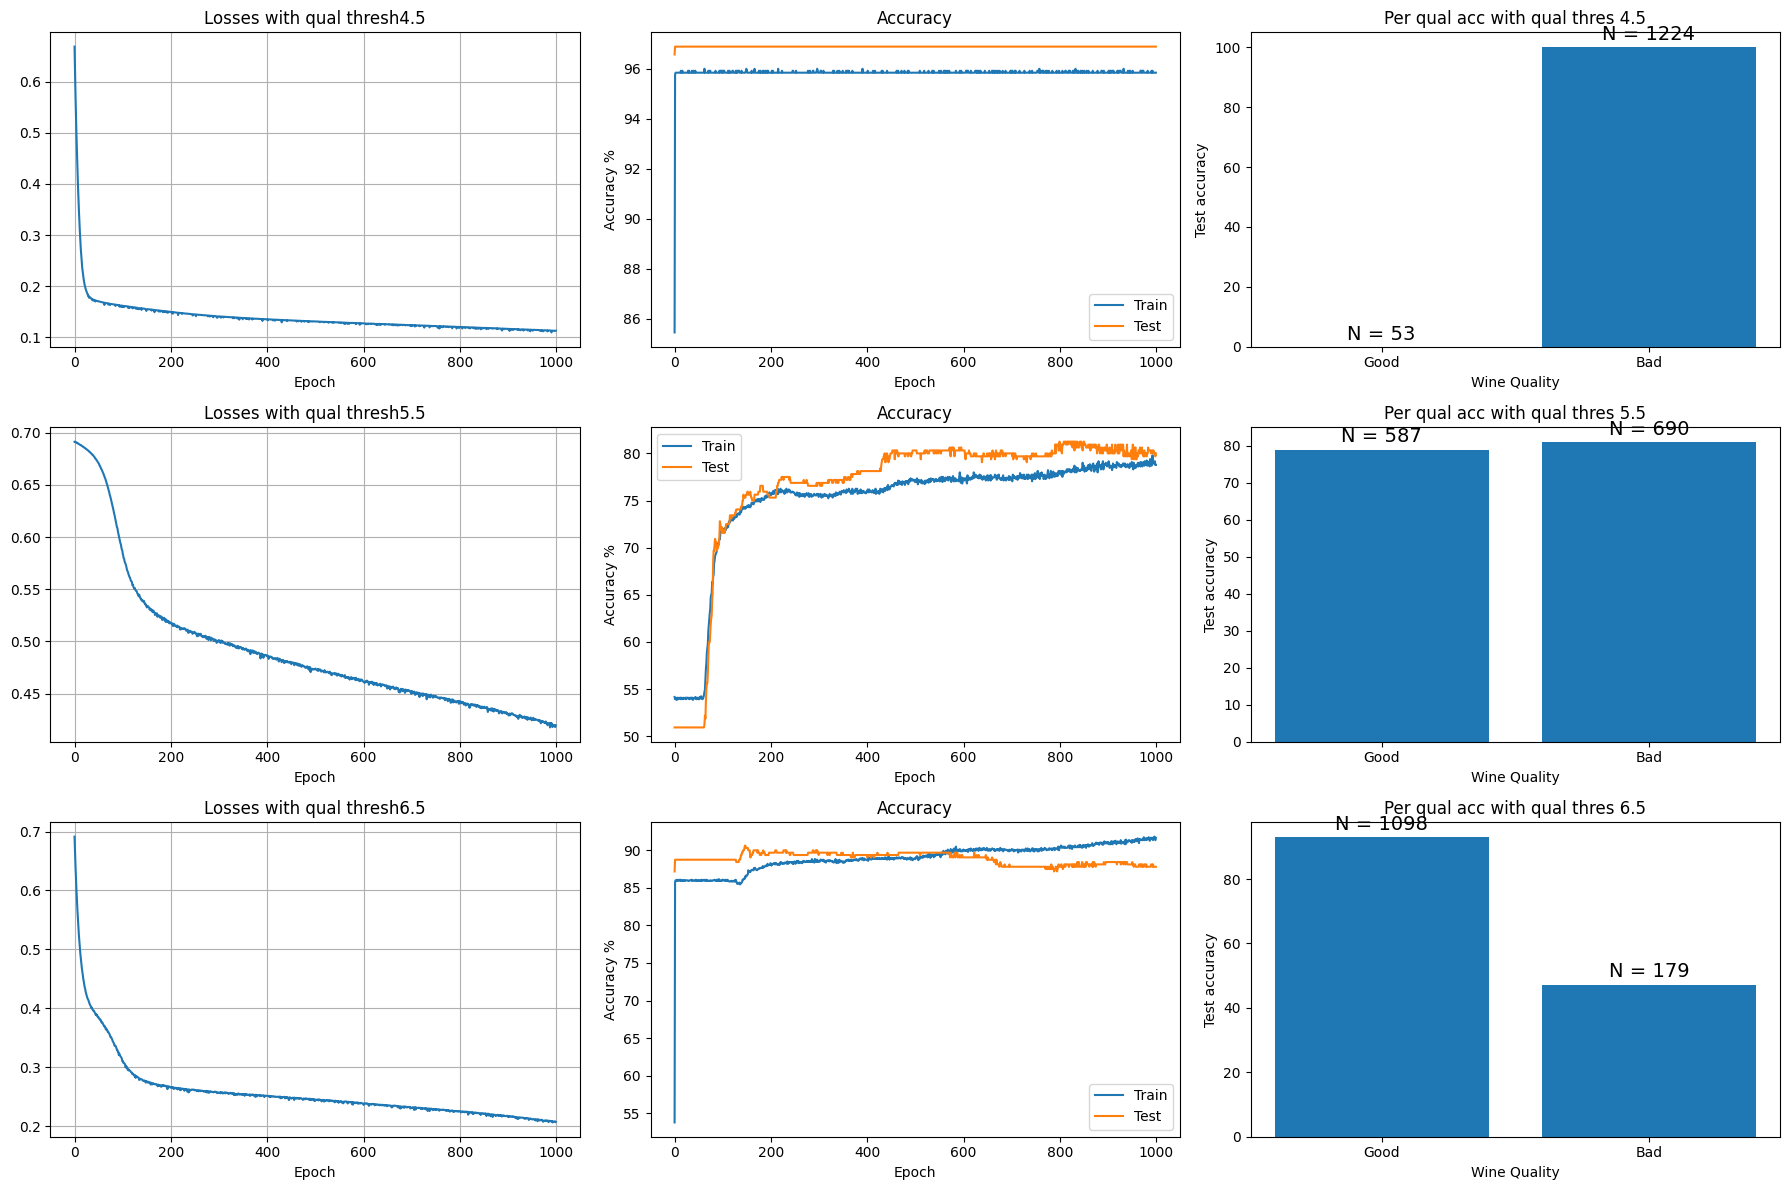

In [18]:
fig, ax = plt.subplots(3,3,figsize = (18, 12))
qualityThresholds = [4, 5, 6]

for quali in range(len(qualityThresholds)):

    train_loader, test_loader = createAdataset(qualityThresholds[quali])
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainTheModel()

    # compute the accuracy per quality type
    X, y = next(iter(test_loader))
    itemAccuracy = ((winenet(X) > 0) == y).float()
    perQualAcc = [100*torch.mean(itemAccuracy[y == 0]),
                  100*torch.mean(itemAccuracy[y == 1])]

    ax[quali, 0].plot(losses)
    ax[quali, 0].set_title('Losses with qual thresh' + str(qualityThresholds[quali] + .5))
    ax[quali, 0].set_xlabel('Epoch')
    ax[quali, 0].grid()

    ax[quali, 1].plot(trainAcc, label = 'Train')
    ax[quali, 1].plot(testAcc, label = 'Test')
    ax[quali, 1].set_title('Accuracy')
    ax[quali, 1].set_xlabel('Epoch')
    ax[quali, 1].set_ylabel('Accuracy %')
    ax[quali, 1].legend()

    bh = ax[quali, 2].bar(['Good', 'Bad'], perQualAcc)
    ax[quali, 2].set_xlabel('Wine Quality')
    ax[quali, 2].set_ylabel('Test accuracy')
    ax[quali, 2].set_title('Per qual acc with qual thres '+str(qualityThresholds[quali] + .5))

    for i, r in enumerate(bh):
        N = torch.sum(train_loader.dataset.tensors[1] == i).item()
        ax[quali, 2].text(r.get_x() + r.get_width()/2, r.get_height()+1, 'N = %s' %N, ha = 'center', va = 'bottom', fontsize = 14)

plt.tight_layout()
plt.show()







